In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Attention, Activation, MaxPooling1D, Flatten, Dense, LSTM, Conv1D, Flatten, AveragePooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [20]:
train = pd.read_csv('588-training-modified.csv')
test = pd.read_csv('588-testing-modified.csv')

In [22]:
in_w = 180
interval = int(in_w/10*2)
out_60 = 13
out_30 = 7
out_1 = 1

train_x = np.zeros((int((train.shape[0]-out_60*5-in_w)/5)+1, in_w, train.shape[1]))
train_60 = np.zeros((int((train.shape[0]-out_60*5-in_w)/5)+1, out_60))
train_30 = np.zeros((int((train.shape[0]-out_60*5-in_w)/5)+1, out_30))
train_1 = np.zeros((int((train.shape[0]-out_60*5-in_w)/5)+1, out_1))

for i in range (0, train_x.shape[0]):
    train_x[i] = train[i*5:in_w+i*5]
    train_60[i] = train.iloc[np.where(train['BGL']>0)[0][interval+i:interval+(i)+out_60]]['BGL']
    train_30[i] = train_60[i][0:7]
    train_1[i] = train_60[i][0]
    
test_x = np.zeros((int((test.shape[0]-out_60*5-in_w)/5)+1, in_w, test.shape[1]))
test_60 = np.zeros((int((test.shape[0]-out_60*5-in_w)/5)+1, out_60))
test_30 = np.zeros((int((test.shape[0]-out_60*5-in_w)/5)+1, out_30))
test_1 = np.zeros((int((test.shape[0]-out_60*5-in_w)/5)+1, out_1))
              
for i in range (0, test_x.shape[0]):
    test_x[i] = test[i*5:in_w+i*5]
    test_60[i] = test.iloc[np.where(test['BGL']>0)[0][interval+i:interval+i+out_60]]['BGL']
    test_30[i] = test_60[i][0:7]
    test_1[i] = test_60[i][0]

In [23]:
model_input = Input(shape=(train_x.shape[1], train_x.shape[2]))

x = Conv1D(filters=128, kernel_initializer='RandomNormal', kernel_regularizer=l2(0.05), kernel_size=3, activation='tanh')(model_input)
x = Dropout(0.5)(x)
x = MaxPooling1D(pool_size=2)(x)

x = LSTM(units=60, return_sequences=True, activation='tanh')(x)
x = Dropout(0.5)(x)

x = LSTM(units=50, activation='tanh')(x)
x = Dropout(0.5)(x)

m_60 = Dense(units = 13, activation='linear', name='m_60')(x)
m_30 = Dense(units = 7, activation='linear', name='m_30')(x)
m_nxt = Dense(units = 1, activation='linear', name='m_nxt')(x)

model = Model(inputs=model_input, outputs=[m_60,m_30,m_nxt])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-03)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 17)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 178, 128)     6656        ['input_4[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 178, 128)     0           ['conv1d_3[0][0]']               
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 89, 128)     0           ['dropout_9[0][0]']              
                                                                                            

In [24]:
start = time.time()

history = model.fit(
    train_x, (train_60,train_30,train_1),
    epochs = 300,
    batch_size = 300,
    validation_data = (test_x, (test_60,test_30,test_1)),
    verbose = True,
    shuffle = True
)

end = time.time()
print('Time taken: ', (end - start)/60)

Epoch 1/300
44/44 [==============================] - 6s 68ms/step - loss: 77451.4922 - m_60_loss: 26421.3691 - m_30_loss: 26596.3398 - m_nxt_loss: 24433.2402 - m_60_mae: 154.5835 - m_30_mae: 155.1503 - m_nxt_mae: 147.9632 - val_loss: 77834.9531 - val_m_60_loss: 26625.1543 - val_m_30_loss: 26783.9453 - val_m_nxt_loss: 24425.4941 - val_m_60_mae: 156.0970 - val_m_30_mae: 156.6090 - val_m_nxt_mae: 148.8972
Epoch 2/300
44/44 [==============================] - 2s 48ms/step - loss: 59362.9648 - m_60_loss: 20340.5879 - m_30_loss: 20496.3750 - m_nxt_loss: 18525.7051 - m_60_mae: 133.5053 - m_30_mae: 134.0880 - m_nxt_mae: 126.4942 - val_loss: 60807.2266 - val_m_60_loss: 20853.3945 - val_m_30_loss: 20991.6523 - val_m_nxt_loss: 18961.9102 - val_m_60_mae: 136.3619 - val_m_30_mae: 136.8726 - val_m_nxt_mae: 129.2548
Epoch 3/300
44/44 [==============================] - 2s 49ms/step - loss: 45936.4180 - m_60_loss: 15775.3311 - m_30_loss: 15907.6123 - m_nxt_loss: 14253.2314 - m_60_mae: 115.0560 - m_30_ma

Epoch 22/300
44/44 [==============================] - 2s 48ms/step - loss: 8902.0547 - m_60_loss: 2969.8481 - m_30_loss: 2971.8206 - m_nxt_loss: 2960.3049 - m_60_mae: 43.3109 - m_30_mae: 43.3324 - m_nxt_mae: 43.3451 - val_loss: 7753.3872 - val_m_60_loss: 2596.0916 - val_m_30_loss: 2595.3167 - val_m_nxt_loss: 2561.8989 - val_m_60_mae: 39.7752 - val_m_30_mae: 39.7477 - val_m_nxt_mae: 39.4543
Epoch 23/300
44/44 [==============================] - 2s 47ms/step - loss: 9026.4775 - m_60_loss: 3005.1562 - m_30_loss: 3010.2793 - m_nxt_loss: 3010.9631 - m_60_mae: 43.4721 - m_30_mae: 43.4626 - m_nxt_mae: 43.4752 - val_loss: 7702.5435 - val_m_60_loss: 2577.1577 - val_m_30_loss: 2576.3267 - val_m_nxt_loss: 2548.9819 - val_m_60_mae: 39.6239 - val_m_30_mae: 39.5964 - val_m_nxt_mae: 39.3525
Epoch 24/300
44/44 [==============================] - 2s 50ms/step - loss: 8992.2852 - m_60_loss: 2986.3091 - m_30_loss: 2996.8267 - m_nxt_loss: 3009.0725 - m_60_mae: 43.4722 - m_30_mae: 43.5373 - m_nxt_mae: 43.687

Epoch 43/300
44/44 [==============================] - 2s 48ms/step - loss: 8997.7939 - m_60_loss: 3000.1331 - m_30_loss: 3001.3386 - m_nxt_loss: 2996.2754 - m_60_mae: 43.7839 - m_30_mae: 43.8327 - m_nxt_mae: 43.8350 - val_loss: 7528.1299 - val_m_60_loss: 2512.0798 - val_m_30_loss: 2509.8635 - val_m_nxt_loss: 2506.1421 - val_m_60_mae: 39.1061 - val_m_30_mae: 39.0696 - val_m_nxt_mae: 39.0143
Epoch 44/300
44/44 [==============================] - 2s 49ms/step - loss: 9104.5391 - m_60_loss: 3035.7175 - m_30_loss: 3034.5562 - m_nxt_loss: 3034.2207 - m_60_mae: 43.9418 - m_30_mae: 43.9523 - m_nxt_mae: 44.0199 - val_loss: 7528.7900 - val_m_60_loss: 2512.5339 - val_m_30_loss: 2510.1255 - val_m_nxt_loss: 2506.0867 - val_m_60_mae: 39.1097 - val_m_30_mae: 39.0716 - val_m_nxt_mae: 39.0139
Epoch 45/300
44/44 [==============================] - 2s 48ms/step - loss: 9053.0791 - m_60_loss: 3018.8208 - m_30_loss: 3017.6257 - m_nxt_loss: 3016.5911 - m_60_mae: 43.8239 - m_30_mae: 43.8046 - m_nxt_mae: 43.789

Epoch 64/300
44/44 [==============================] - 2s 49ms/step - loss: 4485.9932 - m_60_loss: 1698.6654 - m_30_loss: 1482.5077 - m_nxt_loss: 1303.2067 - m_60_mae: 31.2662 - m_30_mae: 29.0816 - m_nxt_mae: 26.9433 - val_loss: 3423.7109 - val_m_60_loss: 1380.4120 - val_m_30_loss: 1127.1761 - val_m_nxt_loss: 914.4924 - val_m_60_mae: 27.2044 - val_m_30_mae: 24.4027 - val_m_nxt_mae: 21.5675
Epoch 65/300
44/44 [==============================] - 2s 49ms/step - loss: 4369.2134 - m_60_loss: 1663.9248 - m_30_loss: 1445.3257 - m_nxt_loss: 1258.3192 - m_60_mae: 31.0504 - m_30_mae: 28.8259 - m_nxt_mae: 26.5849 - val_loss: 3252.1768 - val_m_60_loss: 1315.7183 - val_m_30_loss: 1067.5792 - val_m_nxt_loss: 867.2174 - val_m_60_mae: 26.2267 - val_m_30_mae: 23.3245 - val_m_nxt_mae: 20.5702
Epoch 66/300
44/44 [==============================] - 2s 49ms/step - loss: 4308.7676 - m_60_loss: 1644.1437 - m_30_loss: 1424.8367 - m_nxt_loss: 1238.1104 - m_60_mae: 30.7393 - m_30_mae: 28.5017 - m_nxt_mae: 26.3415 

Epoch 85/300
44/44 [==============================] - 2s 47ms/step - loss: 3761.1709 - m_60_loss: 1480.2595 - m_30_loss: 1240.9608 - m_nxt_loss: 1037.9636 - m_60_mae: 29.1074 - m_30_mae: 26.6423 - m_nxt_mae: 24.2788 - val_loss: 2729.3064 - val_m_60_loss: 1181.4740 - val_m_30_loss: 883.9885 - val_m_nxt_loss: 661.8515 - val_m_60_mae: 25.2812 - val_m_30_mae: 21.9769 - val_m_nxt_mae: 19.2346
Epoch 86/300
44/44 [==============================] - 2s 48ms/step - loss: 3719.6516 - m_60_loss: 1477.2832 - m_30_loss: 1225.8340 - m_nxt_loss: 1014.5319 - m_60_mae: 29.2224 - m_30_mae: 26.5980 - m_nxt_mae: 24.0629 - val_loss: 2564.1301 - val_m_60_loss: 1122.4979 - val_m_30_loss: 828.9462 - val_m_nxt_loss: 610.6661 - val_m_60_mae: 24.4440 - val_m_30_mae: 21.0266 - val_m_nxt_mae: 18.1376
Epoch 87/300
44/44 [==============================] - 2s 48ms/step - loss: 3652.5813 - m_60_loss: 1451.8745 - m_30_loss: 1201.9088 - m_nxt_loss: 996.7684 - m_60_mae: 28.9807 - m_30_mae: 26.3798 - m_nxt_mae: 23.8417 - v

Epoch 106/300
44/44 [==============================] - 2s 50ms/step - loss: 3483.6899 - m_60_loss: 1396.5897 - m_30_loss: 1143.4214 - m_nxt_loss: 941.3641 - m_60_mae: 28.3176 - m_30_mae: 25.6425 - m_nxt_mae: 23.0816 - val_loss: 1993.1804 - val_m_60_loss: 936.3523 - val_m_30_loss: 638.4243 - val_m_nxt_loss: 416.0802 - val_m_60_mae: 21.0175 - val_m_30_mae: 17.1059 - val_m_nxt_mae: 13.4390
Epoch 107/300
44/44 [==============================] - 2s 48ms/step - loss: 3459.4685 - m_60_loss: 1387.0687 - m_30_loss: 1137.9962 - m_nxt_loss: 932.0642 - m_60_mae: 28.2926 - m_30_mae: 25.7227 - m_nxt_mae: 23.1484 - val_loss: 1950.9287 - val_m_60_loss: 921.0014 - val_m_30_loss: 623.1229 - val_m_nxt_loss: 404.4575 - val_m_60_mae: 20.8235 - val_m_30_mae: 16.8654 - val_m_nxt_mae: 13.2177
Epoch 108/300
44/44 [==============================] - 2s 51ms/step - loss: 3468.8928 - m_60_loss: 1387.5936 - m_30_loss: 1138.9125 - m_nxt_loss: 940.0280 - m_60_mae: 28.1927 - m_30_mae: 25.6081 - m_nxt_mae: 23.1139 - va

Epoch 127/300
44/44 [==============================] - 2s 48ms/step - loss: 3314.4568 - m_60_loss: 1341.4557 - m_30_loss: 1085.4403 - m_nxt_loss: 884.9584 - m_60_mae: 27.7508 - m_30_mae: 25.1091 - m_nxt_mae: 22.6329 - val_loss: 1866.5890 - val_m_60_loss: 895.4025 - val_m_30_loss: 593.6367 - val_m_nxt_loss: 374.9467 - val_m_60_mae: 20.8881 - val_m_30_mae: 16.9956 - val_m_nxt_mae: 13.6020
Epoch 128/300
44/44 [==============================] - 2s 49ms/step - loss: 3358.5637 - m_60_loss: 1365.0441 - m_30_loss: 1100.7776 - m_nxt_loss: 890.1389 - m_60_mae: 27.8819 - m_30_mae: 25.1185 - m_nxt_mae: 22.5019 - val_loss: 1796.9225 - val_m_60_loss: 866.8561 - val_m_30_loss: 570.0826 - val_m_nxt_loss: 357.3723 - val_m_60_mae: 20.6992 - val_m_30_mae: 16.7217 - val_m_nxt_mae: 13.0988
Epoch 129/300
44/44 [==============================] - 2s 49ms/step - loss: 3380.0483 - m_60_loss: 1367.0980 - m_30_loss: 1108.8577 - m_nxt_loss: 901.4697 - m_60_mae: 28.1213 - m_30_mae: 25.3891 - m_nxt_mae: 22.7855 - va

44/44 [==============================] - 2s 48ms/step - loss: 3204.9727 - m_60_loss: 1303.2688 - m_30_loss: 1050.6228 - m_nxt_loss: 848.2380 - m_60_mae: 27.3700 - m_30_mae: 24.6553 - m_nxt_mae: 22.1595 - val_loss: 1932.4707 - val_m_60_loss: 922.3608 - val_m_30_loss: 614.4193 - val_m_nxt_loss: 392.8499 - val_m_60_mae: 21.7602 - val_m_30_mae: 17.9451 - val_m_nxt_mae: 14.5742
Epoch 149/300
44/44 [==============================] - 2s 49ms/step - loss: 3245.1414 - m_60_loss: 1314.3488 - m_30_loss: 1063.8938 - m_nxt_loss: 864.0531 - m_60_mae: 27.5438 - m_30_mae: 24.8808 - m_nxt_mae: 22.4058 - val_loss: 1696.7477 - val_m_60_loss: 833.4145 - val_m_30_loss: 535.4651 - val_m_nxt_loss: 325.0103 - val_m_60_mae: 20.2588 - val_m_30_mae: 16.2331 - val_m_nxt_mae: 12.5774
Epoch 150/300
44/44 [==============================] - 2s 48ms/step - loss: 3263.6675 - m_60_loss: 1329.7000 - m_30_loss: 1070.3278 - m_nxt_loss: 860.7861 - m_60_mae: 27.6407 - m_30_mae: 24.8940 - m_nxt_mae: 22.2573 - val_loss: 1703.6

44/44 [==============================] - 2s 48ms/step - loss: 3121.8164 - m_60_loss: 1287.7496 - m_30_loss: 1020.7820 - m_nxt_loss: 810.1772 - m_60_mae: 27.1427 - m_30_mae: 24.3208 - m_nxt_mae: 21.6568 - val_loss: 1516.2397 - val_m_60_loss: 774.8506 - val_m_30_loss: 472.8160 - val_m_nxt_loss: 265.4629 - val_m_60_mae: 19.5062 - val_m_30_mae: 15.2822 - val_m_nxt_mae: 11.6070
Epoch 191/300
44/44 [==============================] - 2s 49ms/step - loss: 3057.1860 - m_60_loss: 1265.7623 - m_30_loss: 999.4589 - m_nxt_loss: 788.8588 - m_60_mae: 26.8502 - m_30_mae: 24.0414 - m_nxt_mae: 21.3597 - val_loss: 1435.3500 - val_m_60_loss: 743.5867 - val_m_30_loss: 447.2897 - val_m_nxt_loss: 241.3749 - val_m_60_mae: 19.2203 - val_m_30_mae: 14.8926 - val_m_nxt_mae: 10.9120
Epoch 192/300
44/44 [==============================] - 2s 48ms/step - loss: 3101.4456 - m_60_loss: 1278.5189 - m_30_loss: 1015.6984 - m_nxt_loss: 804.1229 - m_60_mae: 27.2876 - m_30_mae: 24.4627 - m_nxt_mae: 21.6217 - val_loss: 1648.27

44/44 [==============================] - 2s 48ms/step - loss: 2994.8987 - m_60_loss: 1245.3855 - m_30_loss: 979.5510 - m_nxt_loss: 766.6475 - m_60_mae: 26.9495 - m_30_mae: 24.0749 - m_nxt_mae: 21.2624 - val_loss: 1380.2361 - val_m_60_loss: 725.6774 - val_m_30_loss: 428.7312 - val_m_nxt_loss: 222.5068 - val_m_60_mae: 18.7480 - val_m_30_mae: 14.4462 - val_m_nxt_mae: 10.5001
Epoch 233/300
44/44 [==============================] - 2s 49ms/step - loss: 3015.2366 - m_60_loss: 1255.1995 - m_30_loss: 986.1564 - m_nxt_loss: 770.5607 - m_60_mae: 26.7816 - m_30_mae: 23.9471 - m_nxt_mae: 21.1935 - val_loss: 1368.9573 - val_m_60_loss: 727.4753 - val_m_30_loss: 424.5609 - val_m_nxt_loss: 213.6012 - val_m_60_mae: 18.7566 - val_m_30_mae: 14.4154 - val_m_nxt_mae: 10.5300
Epoch 234/300
44/44 [==============================] - 2s 49ms/step - loss: 2960.3765 - m_60_loss: 1231.2421 - m_30_loss: 966.2394 - m_nxt_loss: 759.5809 - m_60_mae: 26.5905 - m_30_mae: 23.6994 - m_nxt_mae: 20.9797 - val_loss: 1477.9613

44/44 [==============================] - 2s 47ms/step - loss: 2938.5981 - m_60_loss: 1227.3091 - m_30_loss: 959.6701 - m_nxt_loss: 748.0640 - m_60_mae: 26.4711 - m_30_mae: 23.5167 - m_nxt_mae: 20.7324 - val_loss: 1315.6095 - val_m_60_loss: 702.5356 - val_m_30_loss: 407.3196 - val_m_nxt_loss: 202.1991 - val_m_60_mae: 18.7076 - val_m_30_mae: 14.3946 - val_m_nxt_mae: 10.3781
Epoch 275/300
44/44 [==============================] - 2s 48ms/step - loss: 2926.6907 - m_60_loss: 1218.6863 - m_30_loss: 955.0292 - m_nxt_loss: 749.4174 - m_60_mae: 26.4114 - m_30_mae: 23.5214 - m_nxt_mae: 20.7329 - val_loss: 1258.9143 - val_m_60_loss: 681.7549 - val_m_30_loss: 388.4574 - val_m_nxt_loss: 185.1429 - val_m_60_mae: 18.2159 - val_m_30_mae: 13.7478 - val_m_nxt_mae: 9.4202
Epoch 276/300
44/44 [==============================] - 2s 49ms/step - loss: 2861.5376 - m_60_loss: 1200.3926 - m_30_loss: 932.8516 - m_nxt_loss: 724.7338 - m_60_mae: 26.3217 - m_30_mae: 23.3522 - m_nxt_mae: 20.5038 - val_loss: 1292.8885 

83/83 [==============================] - 1s 10ms/step


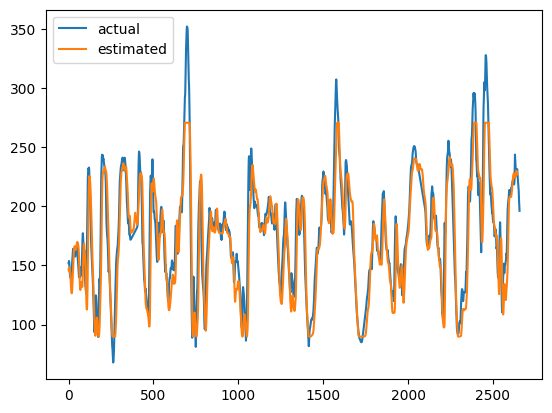

In [31]:
predict = model.predict(test_x)[2]
estimated = predict[0].tolist()
actual = test_60[0].tolist()

for i in range (1,2646):
    estimated.append(predict[i][-1])
    actual.append(test_60[i][-1])
plt.plot(actual)
plt.plot(moving_avarage_smoothing(np.array(estimated),8))
plt.legend(['actual','estimated'])  